 ## This notebook is written by:
 **Gülsüm Yıldırım (221404031)**  
 **Faruk Ortaköylüoğlu (231401032)**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from math import ceil
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [2]:
import time    
start_time = time.time()    

In [3]:
data = pd.read_csv("./mushrooms_mini.csv")
data.head(6)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color
0,p,x,s,n,t,p,f,c,n,k
1,e,x,s,y,t,a,f,c,b,k
2,e,b,s,w,t,l,f,c,b,n
3,p,x,y,w,t,p,f,c,n,n
4,e,x,s,g,f,n,f,w,b,k
5,e,x,y,y,t,a,f,c,b,n


In [4]:
for i, atr in enumerate(data.columns, start=1):
    print(f"\n{i}. Column: {atr}")
    counts = data[atr].value_counts().sort_index()
    percents = data[atr].value_counts(normalize=True).sort_index() * 100
    df = pd.DataFrame({'Count': counts, 'Percent (%)': percents.round(2)})
    print(df.to_string())


1. Column: class
   Count  Percent (%)
e   4208         51.8
p   3916         48.2

2. Column: cap-shape
   Count  Percent (%)
b    452         5.56
c      4         0.05
f   3152        38.80
k    828        10.19
s     32         0.39
x   3656        45.00

3. Column: cap-surface
   Count  Percent (%)
f   2320        28.56
g      4         0.05
s   2556        31.46
y   3244        39.93

4. Column: cap-color
   Count  Percent (%)
b    168         2.07
c     44         0.54
e   1500        18.46
g   1840        22.65
n   2284        28.11
p    144         1.77
r     16         0.20
u     16         0.20
w   1040        12.80
y   1072        13.20

5. Column: bruises
   Count  Percent (%)
f   4748        58.44
t   3376        41.56

6. Column: odor
   Count  Percent (%)
a    400         4.92
c    192         2.36
f   2160        26.59
l    400         4.92
m     36         0.44
n   3528        43.43
p    256         3.15
s    576         7.09
y    576         7.09

7. Column: gill-at

In [5]:
data.isnull().sum()

class              0
cap-shape          0
cap-surface        0
cap-color          0
bruises            0
odor               0
gill-attachment    0
gill-spacing       0
gill-size          0
gill-color         0
dtype: int64

In [6]:
data['class'].unique()

array(['p', 'e'], dtype=object)

In [7]:
data.shape

(8124, 10)

### Let's see the boxplot to analyze data

In [8]:
cols = list(data.columns)
figs = []
for col in cols:
    fig = px.box(data, y=col, points="all", color_discrete_sequence=["#636EFA"])
    fig.update_layout(title=col, showlegend=False, margin=dict(l=40, r=40, t=40, b=40))
    figs.append(fig)

rows = ceil(len(cols) / 5)
fig = make_subplots(rows=rows, cols=5, subplot_titles=cols)

for i, col in enumerate(cols):
    r, c = divmod(i, 5)
    trace = go.Box(y=data[col], boxpoints="outliers", name=col, marker_color="#636EFA")
    fig.add_trace(trace, row=r+1, col=c+1)


total_plots = rows * 5
if total_plots > len(cols):
    for j in range(len(cols), total_plots):
        r, c = divmod(j, 5)
        fig.add_trace(go.Scatter(x=[], y=[]), row=r+1, col=c+1)
        fig.update_xaxes(visible=False, row=r+1, col=c+1)
        fig.update_yaxes(visible=False, row=r+1, col=c+1)

fig.update_layout(height=400 * rows,width=1200,title_text="Interactive Boxplots of Mushroom Features", showlegend=False,template="plotly_white")
fig.show()

### As we can see veil-type data has one option and it is redundant so we'll remove it

In [9]:
#data = data.drop(columns='veil-type')

Original column number: 10
Column number after One-hot encoding: 51

Highly Correlated for Poisonous
                 class_p
odor_f          0.623842
gill-size_n     0.540024
gill-color_b    0.538808
bruises_f       0.501530
gill-spacing_c  0.348387 

Negatively Correlated for Poisonous
                 class_p
odor_n         -0.785557
gill-size_b    -0.540024
bruises_t      -0.501530
gill-spacing_w -0.348387
gill-color_n   -0.288943


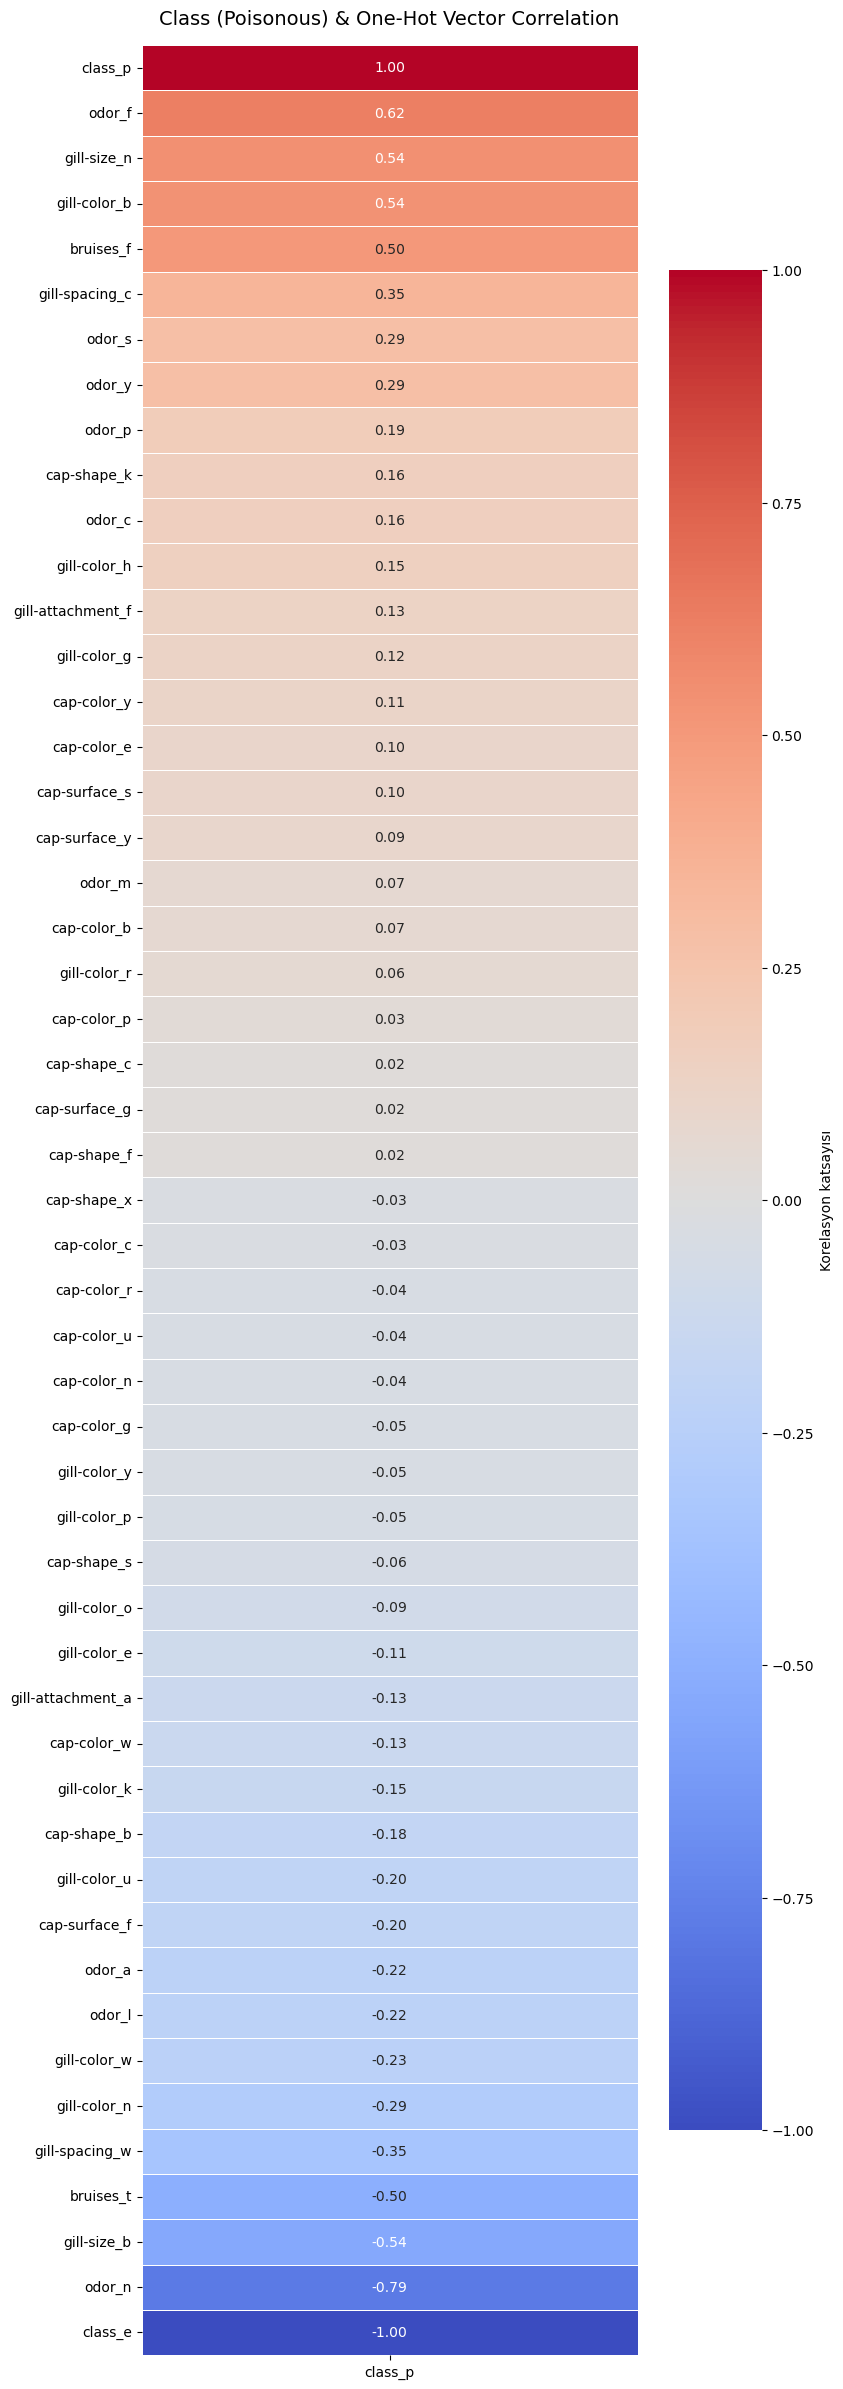

In [10]:
data_encoded = pd.get_dummies(data, drop_first=False)

print(f"Original column number: {data.shape[1]}")
print(f"Column number after One-hot encoding: {data_encoded.shape[1]}\n")

corr = data_encoded.corr()
print('Highly Correlated for Poisonous')
class_corr = corr[['class_p']].sort_values(by='class_p', ascending=False)  
print(class_corr.head(6).tail(5),'\n')  
print('Negatively Correlated for Poisonous')
class_corr2 = corr[['class_p']].sort_values(by='class_p', ascending=True)
print(class_corr2.head(6).tail(5))

plt.figure(figsize=(8, 30))
sns.heatmap(class_corr,annot=True,cmap='coolwarm',linewidths=0.4,fmt=".2f", cbar_kws={'label': 'Korelasyon katsayısı'})
plt.title("Class (Poisonous) & One-Hot Vector Correlation", fontsize=14, pad=15)
plt.show()

In [11]:
data_encoded.corr()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y
class_e,1.000000,-1.000000,0.182567,-0.023007,-0.018526,-0.163565,0.060664,0.026886,0.195415,-0.023007,...,-0.120285,-0.150694,0.149641,0.288943,0.085962,0.050380,-0.056426,0.195359,0.231316,0.046828
class_p,-1.000000,1.000000,-0.182567,0.023007,0.018526,0.163565,-0.060664,-0.026886,-0.195415,0.023007,...,0.120285,0.150694,-0.149641,-0.288943,-0.085962,-0.050380,0.056426,-0.195359,-0.231316,-0.046828
cap-shape_b,0.182567,-0.182567,1.000000,-0.005387,-0.193260,-0.081769,-0.015264,-0.219564,-0.091638,0.018820,...,0.122587,-0.076382,0.101547,0.034751,0.075558,-0.070747,0.105523,-0.061628,0.084884,0.064095
cap-shape_c,-0.023007,0.023007,-0.005387,1.000000,-0.017672,-0.007477,-0.001396,-0.020077,-0.014032,0.249631,...,-0.007089,-0.006984,-0.005104,-0.008542,-0.001978,-0.010527,-0.001208,-0.005635,0.037634,0.051922
cap-shape_f,-0.018526,0.018526,-0.193260,-0.017672,1.000000,-0.268226,-0.050070,-0.720235,0.064801,-0.006285,...,-0.048604,0.072336,-0.025790,0.007077,-0.025233,0.059448,0.012513,0.032947,-0.013773,-0.025588
cap-shape_k,-0.163565,0.163565,-0.081769,-0.007477,-0.268226,1.000000,-0.021185,-0.304733,-0.158942,0.010863,...,-0.062672,-0.106010,-0.077465,-0.110226,0.043614,-0.126160,-0.018337,-0.085533,-0.024646,0.056590
cap-shape_s,0.060664,-0.060664,-0.015264,-0.001396,-0.050070,-0.021185,1.000000,-0.056884,0.099464,-0.001396,...,0.034160,-0.019789,0.057523,0.022700,-0.005604,0.010775,-0.003423,-0.015967,-0.026205,-0.006505
cap-shape_x,0.026886,-0.026886,-0.219564,-0.020077,-0.720235,-0.304733,-0.056884,1.000000,0.063511,-0.020077,...,0.025254,0.031611,0.018568,0.041612,-0.035827,0.050202,-0.049239,0.050401,-0.009010,-0.040379
cap-surface_f,0.195415,-0.195415,-0.091638,-0.014032,0.064801,-0.158942,0.099464,0.063511,1.000000,-0.014032,...,0.091442,0.097993,0.004350,0.062372,-0.056338,0.150562,-0.034415,0.113677,-0.017852,-0.065397
cap-surface_g,-0.023007,0.023007,0.018820,0.249631,-0.006285,0.010863,-0.001396,-0.020077,-0.014032,1.000000,...,-0.007089,-0.006984,-0.005104,-0.008542,-0.001978,-0.010527,-0.001208,-0.005635,0.053262,-0.002296


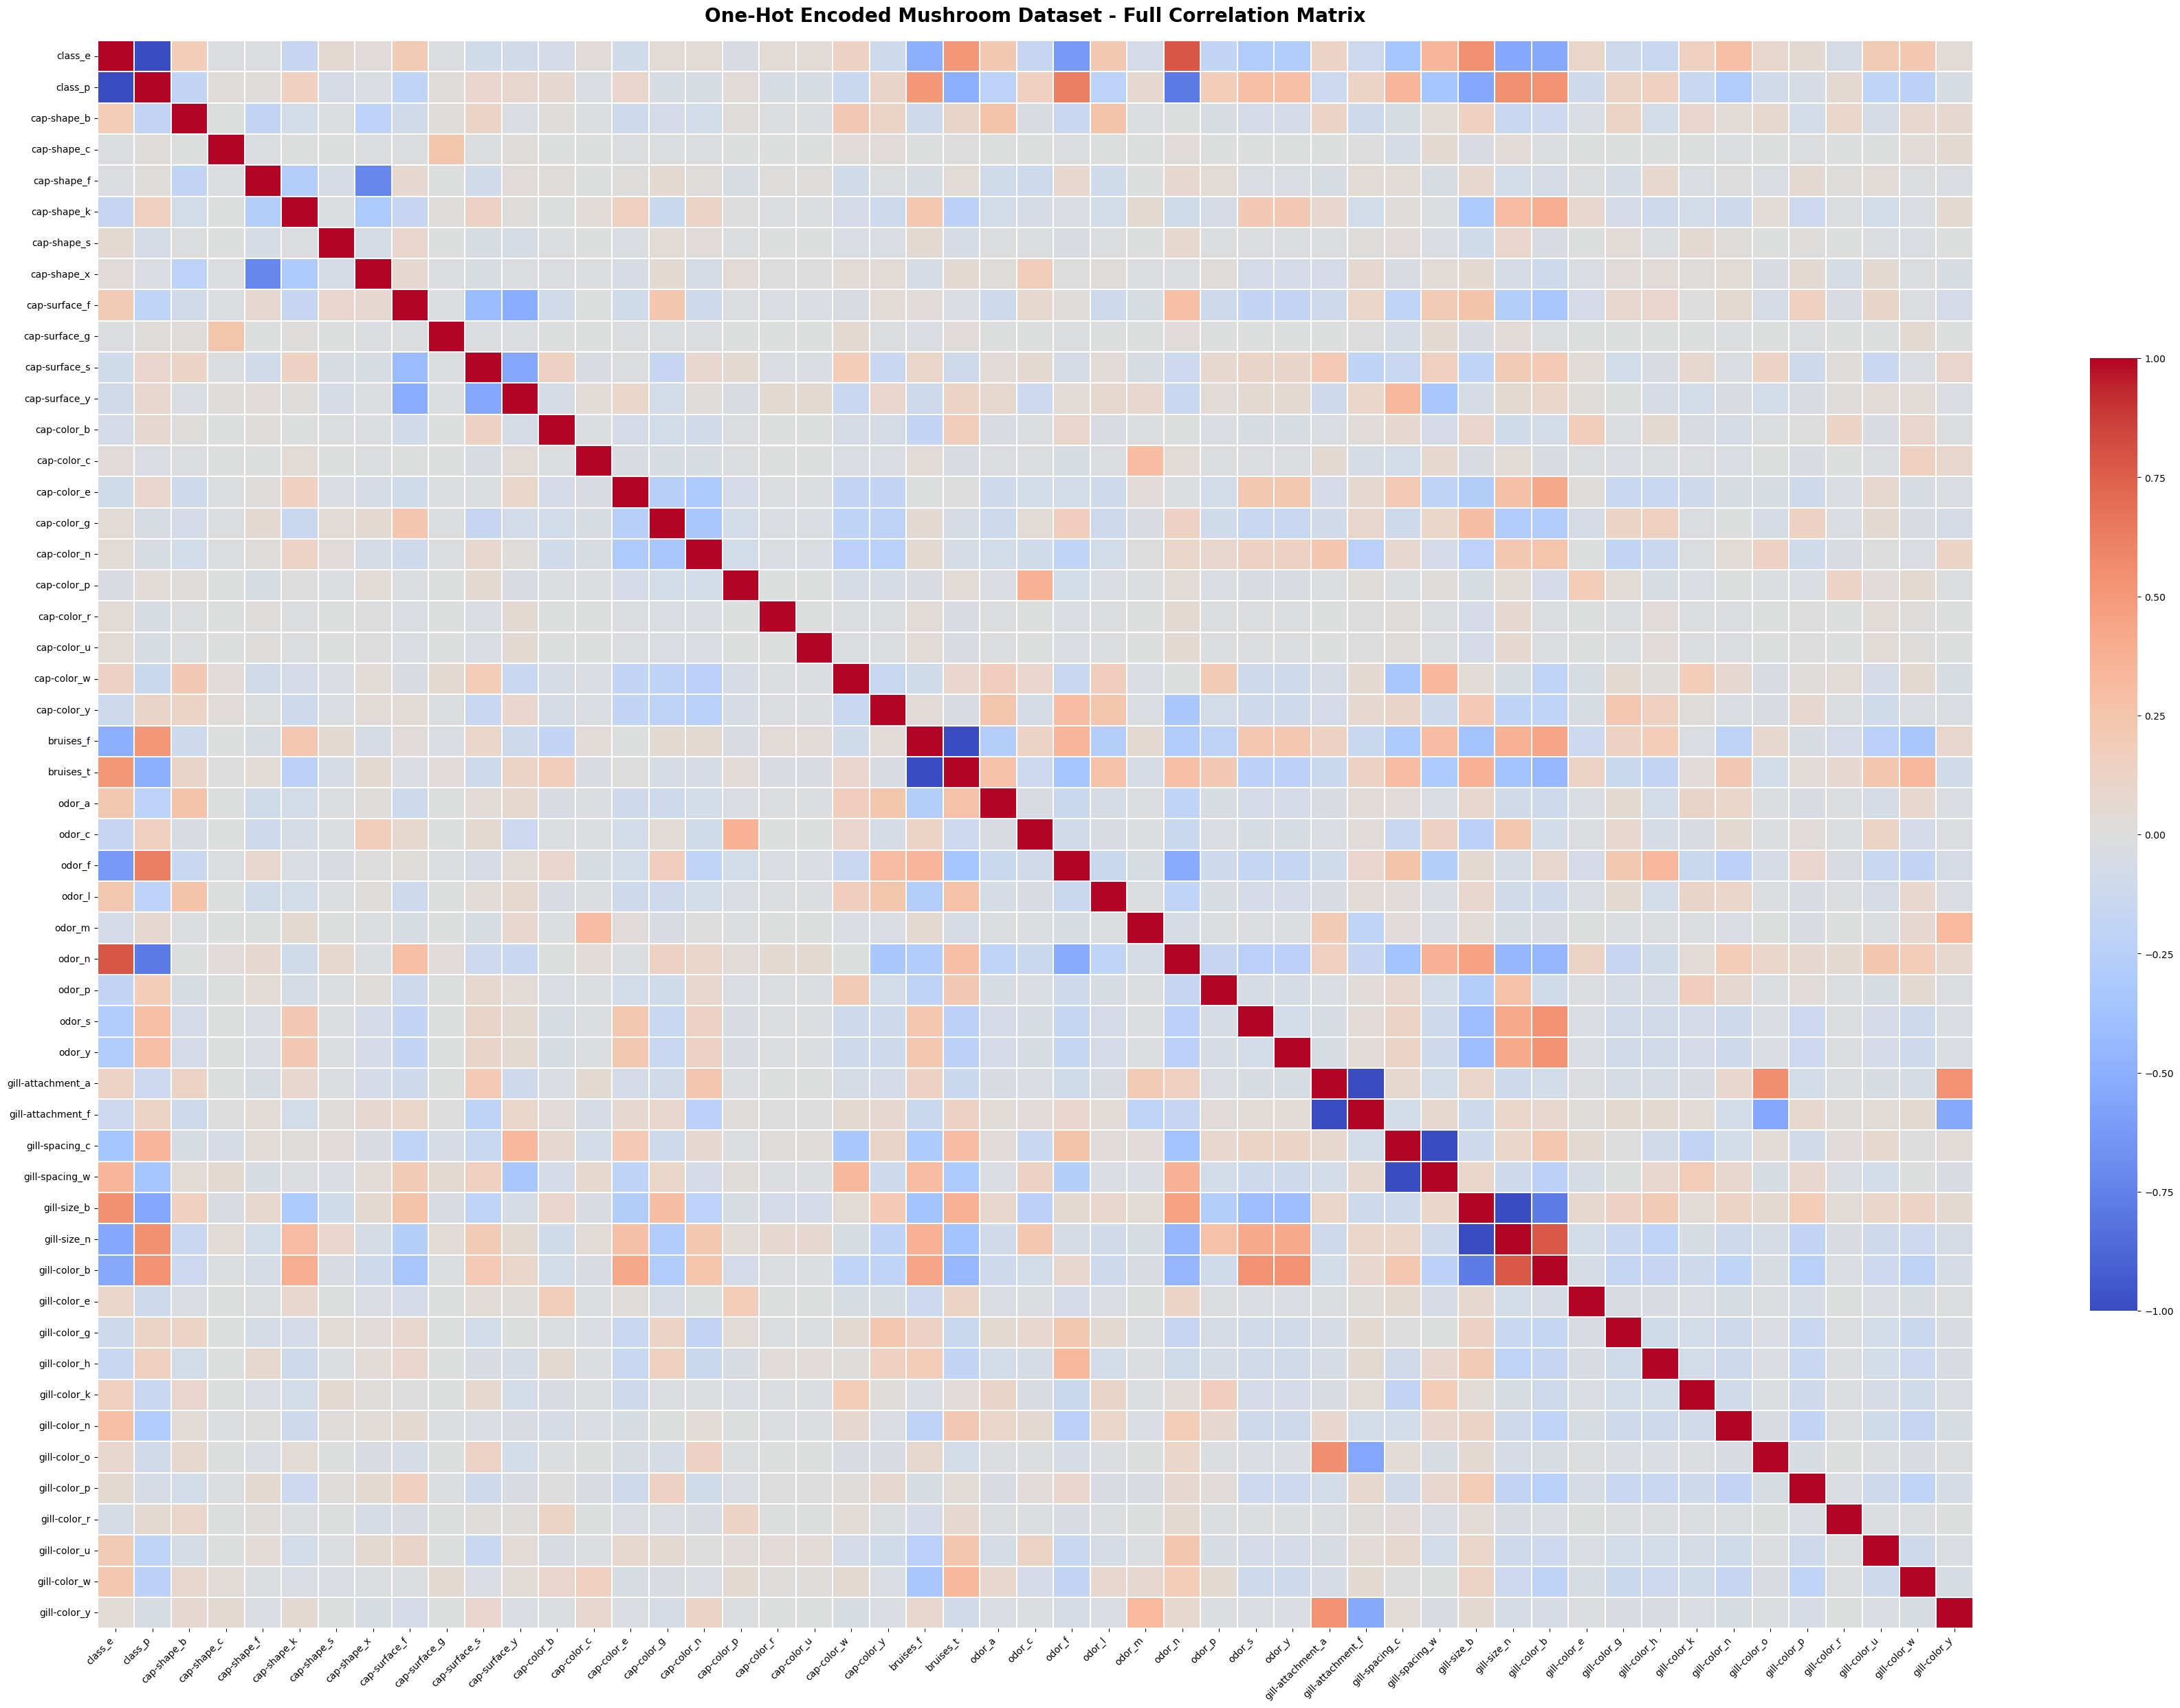

In [12]:
plt.figure(figsize=(44, 30))
sns.heatmap(data_encoded.corr(),cmap="coolwarm",center=0,square=False,linewidths=0.1,cbar_kws={'shrink': 0.6})
plt.title("One-Hot Encoded Mushroom Dataset - Full Correlation Matrix", fontsize=20, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [13]:
data_encoded = pd.get_dummies(data, drop_first=True)
data_encoded.head(6)

,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y
0,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
filtered = data_encoded.corr() 
filtered.head()

,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y
class_p,1.000000,0.023007,0.018526,0.163565,-0.060664,-0.026886,0.023007,0.095454,0.088677,-0.030910,...,0.120285,0.150694,-0.149641,-0.288943,-0.085962,-0.050380,0.056426,-0.195359,-0.231316,-0.046828
cap-shape_c,0.023007,1.000000,-0.017672,-0.007477,-0.001396,-0.020077,0.249631,-0.015038,0.015893,-0.001638,...,-0.007089,-0.006984,-0.005104,-0.008542,-0.001978,-0.010527,-0.001208,-0.005635,0.037634,0.051922
cap-shape_f,0.018526,-0.017672,1.000000,-0.268226,-0.050070,-0.720235,-0.006285,-0.093397,0.029076,-0.003687,...,-0.048604,0.072336,-0.025790,0.007077,-0.025233,0.059448,0.012513,0.032947,-0.013773,-0.025588
cap-shape_k,0.163565,-0.007477,-0.268226,1.000000,-0.021185,-0.304733,0.010863,0.137988,0.015261,0.041662,...,-0.062672,-0.106010,-0.077465,-0.110226,0.043614,-0.126160,-0.018337,-0.085533,-0.024646,0.056590
cap-shape_s,-0.060664,-0.001396,-0.050070,-0.021185,1.000000,-0.056884,-0.001396,-0.042607,-0.051272,-0.004641,...,0.034160,-0.019789,0.057523,0.022700,-0.005604,0.010775,-0.003423,-0.015967,-0.026205,-0.006505


In [15]:
pairs = filtered.unstack()
pairs = pairs.drop_duplicates()
pairs = pairs[pairs!=1]
sorted_pairs = pairs.sort_values(ascending=False)

print('Highest correlation among features')
sorted_pairs.head(10)

Highest correlation among features


class_p      odor_f            0.623842
             gill-size_n       0.540024
odor_y       gill-size_n       0.412899
odor_s       gill-size_n       0.412899
cap-color_p  odor_c            0.372130
odor_n       gill-spacing_w    0.371333
bruises_t    gill-color_w      0.335202
odor_f       gill-color_h      0.324394
cap-color_w  gill-spacing_w    0.320419
odor_m       gill-color_y      0.319046
dtype: float64

In [16]:
X = data_encoded.iloc[:,1:]
y = data_encoded.iloc[:,0]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: class_p, dtype: uint8

In [17]:
X.describe()

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,...,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,...,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,0.000492,0.387986,0.101920,0.003939,0.450025,0.000492,0.314623,0.399311,0.005416,0.184638,...,0.092565,0.090103,0.050222,0.129000,0.007878,0.183653,0.002954,0.060561,0.147957,0.010586
std,0.022185,0.487321,0.302562,0.062641,0.497527,0.022185,0.464394,0.489787,0.073399,0.388028,...,0.289840,0.286347,0.218415,0.335221,0.088413,0.387225,0.054276,0.238539,0.355079,0.102348
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
pca = PCA()
pca.fit_transform(X)

array([[ 3.83711648e-01, -1.07536510e+00, -8.35557987e-04, ...,
         1.33825432e-02,  1.00041477e-04, -6.97649746e-04],
       [-6.25684178e-02, -5.31369103e-01,  6.43091662e-01, ...,
        -8.53836395e-03,  1.25391226e-02,  3.11245133e-04],
       [-2.66703860e-01, -5.41860064e-01, -1.16093355e-01, ...,
         1.26251546e-02, -4.78873631e-03, -2.08938222e-03],
       ...,
       [-3.23904476e-01, -4.72919344e-01, -1.15108694e+00, ...,
        -4.32971211e-02,  1.80571142e-02,  8.62998848e-03],
       [ 1.04299937e+00, -4.59252563e-02, -5.08805955e-01, ...,
        -1.70310355e-03, -2.67473730e-03,  7.88410135e-04],
       [-1.77304259e-01, -1.14340858e+00, -1.23382766e-03, ...,
         8.68635184e-03, -3.14571969e-03, -7.66887575e-03]])

In [19]:
covariance = pca.get_covariance()
explained_variance = pca.explained_variance_ratio_

In [20]:
explained_variance.sum()

0.9999999999999999

In [21]:
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(1, 50)),y=explained_variance,name='Individual explained variance',marker=dict(color='lightblue', opacity=0.6)))

fig.update_layout(
    template='plotly_dark',  
    title='Explained Variance by Principal Components',
    xaxis_title='Principal Components',
    yaxis_title='Explained Variance Ratio',
    legend=dict(x=0.8, y=1.05),
    margin=dict(l=40, r=40, t=60, b=40),
    width=1900,
    height=1000
)
fig.show()

In [22]:
cumulative_variance = np.cumsum(explained_variance)
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(1, len(explained_variance) + 1)),y=explained_variance,name='Individual Explained Variance',marker=dict(color='lightblue', opacity=0.6)))


fig.add_trace(go.Scatter(
    x=list(range(1, len(explained_variance) + 1)),
    y=cumulative_variance,
    mode='lines+markers',
    name='Cumulative Explained Variance',
    line=dict(color='orange', width=3),
    marker=dict(size=6)))

fig.update_layout(
    template='plotly_dark',
    title='Explained Variance by Principal Components',
    xaxis_title='Principal Components',
    yaxis_title='Explained Variance Ratio',
    legend=dict(x=0.75, y=1.05),
    margin=dict(l=40, r=40, t=60, b=40),
    width=1900,
    height=1000)

fig.show()

In [23]:
pc1_loadings = pd.Series(pca.components_[0], index=X.columns)
pc1_loadings.sort_values(ascending=False)

gill-size_n          0.456161
odor_f               0.290233
cap-surface_s        0.153489
cap-shape_k          0.141451
odor_s               0.133404
odor_y               0.133404
cap-color_e          0.099665
cap-color_y          0.067913
cap-color_n          0.046769
gill-color_g         0.040967
cap-surface_y        0.033544
gill-color_h         0.031942
odor_c               0.024638
odor_p               0.011262
gill-attachment_f    0.006412
odor_m               0.002051
cap-shape_s          0.000263
cap-color_u          0.000143
cap-color_r          0.000143
cap-shape_c         -0.000271
gill-color_y        -0.000353
cap-surface_g       -0.000577
cap-color_c         -0.001733
gill-color_o        -0.001848
gill-color_r        -0.004081
cap-color_p         -0.005124
gill-color_e        -0.014378
odor_l              -0.020391
gill-color_k        -0.022936
cap-shape_x         -0.046366
cap-color_w         -0.055174
cap-shape_f         -0.063361
gill-color_p        -0.083092
gill-color

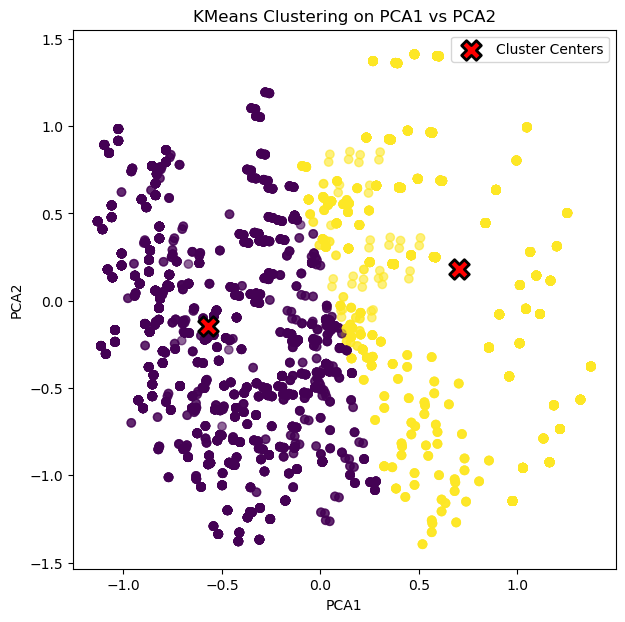

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)
centers = kmeans.cluster_centers_


plt.figure(figsize=(7,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='red', s=200, marker='X', edgecolors='black', linewidths=2,
            label='Cluster Centers')

plt.title("KMeans Clustering on PCA1 vs PCA2")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

### Functions we will use in every model:

In [25]:
def get_eval_metrics(cm):

      tp = cm[1][1]
      tn = cm[0][0]
      fp = cm[0][1]
      fn = cm[1][0]

      print('All of the metrics:\n\n' \
      f'True Positive (TP): {tp}\n'
      f'True Negative (TN): {tn}\n'
      f'False Positive (FP): {fp}\n'
      f'False Negative (FN): {fn}\n')

      accuracy = (tp + tn)/(tp + tn + fp + fn)
      recall = tp/(tp + fn)                     
      precision = tp/(tp + fp)                  
      specificity = tn/(tn + fp)                
      fpr = fp / (fp + tn)    

      print(f'Accuracy: {accuracy:.3}\n'
            f'Recall (Sensitivity): {recall:.3f}\n'
            f'Precision: {precision:.3f}\n'
            f'Specificity: {specificity:.3f}\n')

      print(f'TPR: {round(recall,3)}\n'
            f'FPR: {round(fpr,3)}')

In [26]:
def plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=false_positive_rate,
        y=true_positive_rate,
        mode='lines',
        name=f"AUC = {roc_auc:.5f}",
        line=dict(color='red')
    ))

    fig.add_trace(go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(dash='dash'),
        name='Random'
    ))

    fig.update_layout(
        title='Receiver Operating Characteristic',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        width=800,
        height=800,
        legend=dict(x=0.75, y=0.1)
    )

    fig.show()

In [27]:
def mpl_plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc):
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [28]:
def plot_roc_curve_styled(false_positive_rate, true_positive_rate, roc_auc):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=false_positive_rate,
        y=true_positive_rate,
        mode='lines',
        name=f"AUC = {roc_auc:.5f}",          
        line=dict(color='#00feff', width=3),  
        fill='tozeroy',                       
        fillcolor='rgba(0, 254, 255, 0.15)',  

    ))

    fig.add_trace(go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(dash='dash', color='rgba(255, 255, 255, 0.5)'), 
        name='Random',
        hoverinfo='skip'
    ))

    fig.update_layout(
        template='plotly_dark',
        title=dict(
            text='<b>Receiver Operating Characteristic</b>',
            font=dict(size=20, color='white'),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title='False Positive Rate',
            showgrid=False,
            zeroline=False
        ),
        yaxis=dict(
            title='True Positive Rate',
            showgrid=True,
            gridcolor='rgba(255,255,255,0.1)',
            zeroline=False
        ),
        width=800,
        height=800,
        legend=dict(
            x=0.75, 
            y=0.1,
            bgcolor="rgba(0,0,0,0)",  
            bordercolor="rgba(255,255,255,0.2)",
            borderwidth=1
        ),
        margin=dict(l=50, r=50, t=80, b=50)
    )

    fig.show()

In [29]:
def print_confusion_matrix(cm):
    print('Here is the correlation matrix:')    
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Predicted Edible', 'Predicted Poisonous'],yticklabels=['Actual Edible', 'Actual Poisonous'],cbar=False)
    plt.xlabel('Predict')
    plt.ylabel('Real')
    plt.show()
    return 

# Models with one hot encoding

In [30]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.head()

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,...,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y
7873,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6515,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6141,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2764,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
438,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


## Gaussian Naive Bayes

In [31]:
model_naive = GaussianNB()
model_naive.fit(X_train, y_train)

GaussianNB()

In [32]:
y_prob = model_naive.predict_proba(X_test)[:,1]   
y_pred = np.where(y_prob > 0.5, 1, 0) 
print('Score:', round(model_naive.score(X_test, y_test),4))
print("Number of mislabeled points from %d points : %d"% (X_test.shape[0],(y_test!= y_pred).sum()))

Score: 0.9895
Number of mislabeled points from 1625 points : 17


In [33]:
scores = cross_val_score(model_naive, X, y, cv=10, scoring='recall')
print('All of the scores:', scores,'\n')
print('Mean of the scores:', round(scores.mean(),4))

All of the scores: [0.42857143 0.99744898 0.98979592 0.9744898  0.91071429 0.91581633
 1.         1.         0.99232737 0.99488491] 

Mean of the scores: 0.9204


Here is the correlation matrix:


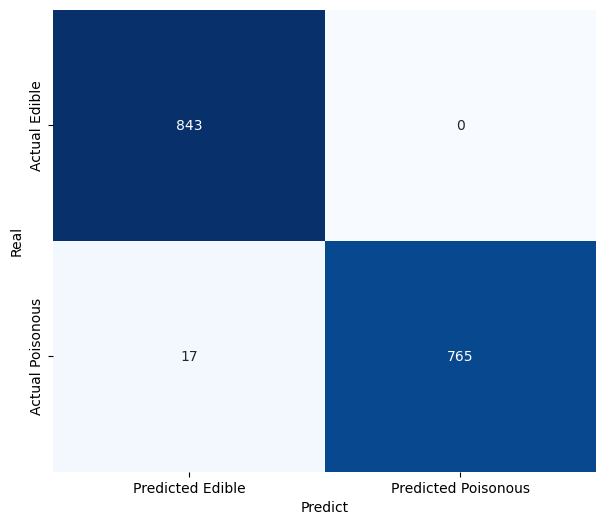

In [34]:
confusion_matrix=metrics.confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)

print_confusion_matrix (cm)

In [35]:
get_eval_metrics(cm)

All of the metrics:

True Positive (TP): 765
True Negative (TN): 843
False Positive (FP): 0
False Negative (FN): 17

Accuracy: 0.99
Recall (Sensitivity): 0.978
Precision: 1.000
Specificity: 1.000

TPR: 0.978
FPR: 0.0


In [36]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test,
    y_prob,
    drop_intermediate=False
 )
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC:", round(roc_auc,5))

AUC: 0.99839


In [37]:
prediction_summary = pd.DataFrame({
    "sample_index": X_test.index,
    "probability": y_prob,
    "predicted": y_pred,
    "actual": y_test.values
})

prediction_summary["is_correct"] = prediction_summary["predicted"] == prediction_summary["actual"]
prediction_summary = prediction_summary.sort_values(by="probability", ascending=False).reset_index(drop=True)

total_positives = (prediction_summary["actual"] == 1).sum()
total_negatives = (prediction_summary["actual"] == 0).sum()

prediction_summary["tp"] = (prediction_summary["actual"] == 1).astype(int).cumsum()
prediction_summary["fp"] = (prediction_summary["actual"] == 0).astype(int).cumsum()
prediction_summary["tn"] = total_negatives - prediction_summary["fp"]
prediction_summary["fn"] = total_positives - prediction_summary["tp"]
prediction_summary["tpr"] = prediction_summary["tp"] / total_positives
prediction_summary["fpr"] = prediction_summary["fp"] / total_negatives
prediction_summary.head()

,sample_index,probability,predicted,actual,is_correct,tp,fp,tn,fn,tpr,fpr
0,4269,1.0,1,1,True,1,0,843,781,0.001279,0.0
1,3955,1.0,1,1,True,2,0,843,780,0.002558,0.0
2,6747,1.0,1,1,True,3,0,843,779,0.003836,0.0
3,5027,1.0,1,1,True,4,0,843,778,0.005115,0.0
4,5792,1.0,1,1,True,5,0,843,777,0.006394,0.0


In [38]:
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

In [39]:
plot_roc_curve_styled(false_positive_rate,true_positive_rate,roc_auc)

## Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression

regression = LinearRegression()
regression.fit(X_train, y_train)


LinearRegression()

In [41]:
# We only use rmse for the linear regression model  
cv_rmse_scores = np.sqrt(-cross_val_score(regression, X, y, cv=10, scoring="neg_mean_squared_error"))
print(f"Cross-validated RMSE (mean): {cv_rmse_scores.mean():.4f}")

Cross-validated RMSE (mean): 0.0867


In [42]:
y_train_pred = regression.predict(X_train)
y_test_pred = regression.predict(X_test)
y_test_pred_clipped = np.clip(y_test_pred, 0, 1)
y_test_linear_class = (y_test_pred_clipped >= 0.5).astype(int)

Here is the correlation matrix:


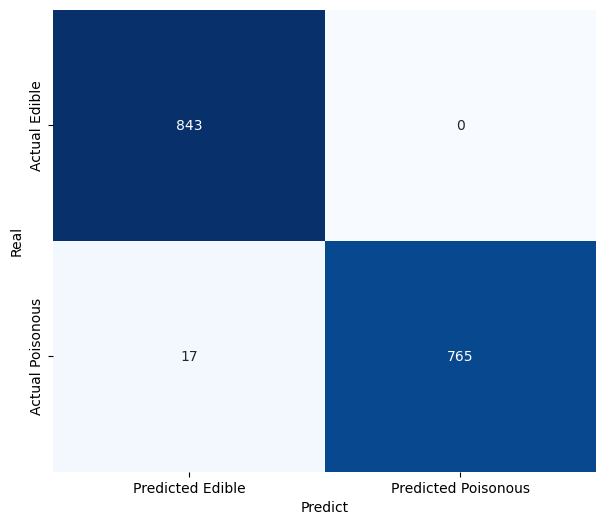

In [43]:
lin_reg_confusion_matrix = metrics.confusion_matrix(y_test, y_test_linear_class)
pd.DataFrame(lin_reg_confusion_matrix,columns=["Predicted 0", "Predicted 1"],index=["Actual 0", "Actual 1"])
print_confusion_matrix(lin_reg_confusion_matrix)

In [44]:
get_eval_metrics(lin_reg_confusion_matrix)

All of the metrics:

True Positive (TP): 765
True Negative (TN): 843
False Positive (FP): 0
False Negative (FN): 17

Accuracy: 0.99
Recall (Sensitivity): 0.978
Precision: 1.000
Specificity: 1.000

TPR: 0.978
FPR: 0.0


In [45]:
false_positive_rate_lr, true_positive_rate_lr, thresholds_lr = roc_curve(
    y_test,
    y_test_pred_clipped
)
roc_auc_lr = auc(false_positive_rate_lr, true_positive_rate_lr)
print("AUC:", round(roc_auc_lr,5))

AUC: 0.99972


In [46]:
plot_roc_curve(false_positive_rate_lr, true_positive_rate_lr, roc_auc_lr)

In [47]:
plot_roc_curve_styled(false_positive_rate_lr, true_positive_rate_lr, roc_auc_lr)

## Logistic Regression
Standartlaştırılmış veriler üzerinde lojistik regresyon kurup hiperparametre araması ile en iyi modeli seçiyoruz;
böylece lineer sınırlayıcı ile ne kadar performans alabildiğimizi güvenilir şekilde ölçebiliyoruz.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced"))
])

log_reg_param_grid = {
    "log_reg__C": np.logspace(-3, 2, 6),
    "log_reg__penalty": ["l1", "l2"]
}

log_reg_grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_param_grid,
    scoring={
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc",
        
    },
    refit="recall",
    cv=5,
    n_jobs=-1,
    verbose=0
)
log_reg_grid_search.fit(X_train, y_train)
log_reg_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'log_reg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'log_reg__penalty': ['l1', 'l2']},
             refit='recall',
             scoring={'f1': 'f1', 'recall': 'recall', 'roc_auc': 'roc_auc'})

In [49]:
print(f"Best CV Recall: {log_reg_grid_search.best_score_:.4f}")
print("Best Params:", log_reg_grid_search.best_params_)

Best CV Recall: 0.9936
Best Params: {'log_reg__C': 10.0, 'log_reg__penalty': 'l1'}


In [50]:
best_log_reg_model = log_reg_grid_search.best_estimator_

log_reg_cv_recall = cross_val_score(best_log_reg_model, X, y, cv=10, scoring="recall")
log_reg_cv_accuracy = cross_val_score(best_log_reg_model, X, y, cv=10, scoring="accuracy")
log_reg_cv_f1 = cross_val_score(best_log_reg_model, X, y, cv=10, scoring="f1")
log_reg_cv_auc = cross_val_score(best_log_reg_model, X, y, cv=10, scoring="roc_auc")

log_reg_scores = pd.DataFrame({
    "metric": [
        "Train Accuracy",
        "Test Accuracy",
        "CV Accuracy (mean)",
        "CV Accuracy (std)",
        "CV Recall (mean)",
        "CV F1 (mean)",
        "CV ROC-AUC (mean)"
    ],
    "score": [
        best_log_reg_model.score(X_train, y_train),
        best_log_reg_model.score(X_test, y_test),
        log_reg_cv_accuracy.mean(),
        log_reg_cv_accuracy.std(),
        log_reg_cv_recall.mean(),
        log_reg_cv_f1.mean(),
        log_reg_cv_auc.mean()
    ]
})

log_reg_scores


,metric,score
0,Train Accuracy,0.995999
1,Test Accuracy,0.997538
2,CV Accuracy (mean),0.955336
3,CV Accuracy (std),0.094032
4,CV Recall (mean),0.926786
5,CV F1 (mean),0.938589
6,CV ROC-AUC (mean),0.980443


In [51]:
print('All of the scores:', log_reg_cv_recall,'\n')
print('Mean of the scores:', round(log_reg_cv_recall.mean(),4))

All of the scores: [0.34693878 1.         0.99744898 0.99234694 0.96683673 0.96428571
 1.         1.         1.         1.        ] 

Mean of the scores: 0.9268


Here is the correlation matrix:


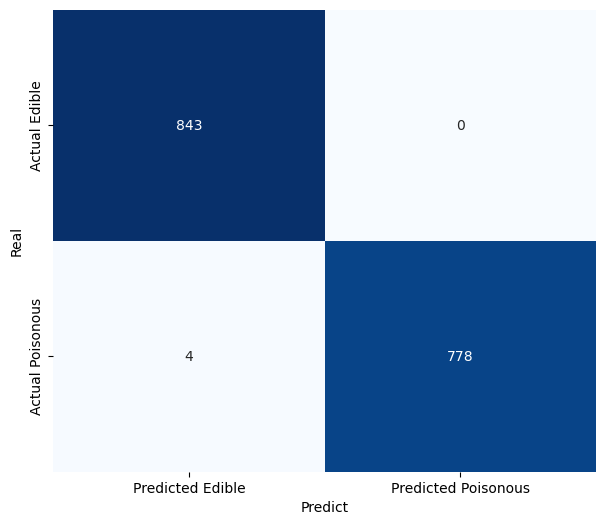

In [52]:
log_reg_y_pred = best_log_reg_model.predict(X_test)
log_reg_y_prob = best_log_reg_model.predict_proba(X_test)[:, 1]

log_reg_confusion_matrix = metrics.confusion_matrix(y_test, log_reg_y_pred)
log_reg_confusion_df = pd.DataFrame(log_reg_confusion_matrix,columns=["Predicted 0", "Predicted 1"],index=["Actual 0", "Actual 1"])
print_confusion_matrix(log_reg_confusion_matrix)

In [53]:
get_eval_metrics(log_reg_confusion_matrix)
#print(metrics.classification_report(y_test, log_reg_y_pred, target_names=["edible", "poisonous"]))

All of the metrics:

True Positive (TP): 778
True Negative (TN): 843
False Positive (FP): 0
False Negative (FN): 4

Accuracy: 0.998
Recall (Sensitivity): 0.995
Precision: 1.000
Specificity: 1.000

TPR: 0.995
FPR: 0.0


In [54]:
log_reg_fpr, log_reg_tpr, log_reg_thresholds = roc_curve(
    y_test,
    log_reg_y_prob,
    drop_intermediate=False
)
log_reg_roc_auc = auc(log_reg_fpr, log_reg_tpr)
print(f"ROC AUC: {log_reg_roc_auc:.5f}")

ROC AUC: 0.99999


In [55]:
log_reg_coefficients = pd.Series(
    best_log_reg_model.named_steps["log_reg"].coef_.ravel(),
    index=X.columns
).sort_values(ascending=False)

log_reg_top_positive = (
    log_reg_coefficients.head(10).to_frame("coefficient")
    .assign(impact="Increases poisonous probability")
)
log_reg_top_negative = (
    log_reg_coefficients.tail(10)
    .sort_values(ascending=True)
    .to_frame("coefficient")
    .assign(impact="Increases edible probability")
)

pd.concat([log_reg_top_positive, log_reg_top_negative])

,coefficient,impact
odor_f,17.516966,Increases poisonous probability
odor_s,6.660556,Increases poisonous probability
odor_y,6.540304,Increases poisonous probability
odor_n,6.119799,Increases poisonous probability
odor_c,5.310954,Increases poisonous probability
gill-size_n,3.944093,Increases poisonous probability
odor_p,3.638620,Increases poisonous probability
bruises_t,2.618174,Increases poisonous probability
odor_m,2.536541,Increases poisonous probability
cap-color_y,1.315404,Increases poisonous probability


In [56]:
plot_roc_curve(log_reg_fpr, log_reg_tpr, log_reg_roc_auc)

In [57]:
plot_roc_curve_styled(log_reg_fpr, log_reg_tpr, log_reg_roc_auc)

## Decision Tree

In [58]:
tree_param_grid = {
    "max_depth": [5, 10, 15, 20, 25],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 6],
    "criterion": ["gini", "entropy", "log_loss"]
}

decision_tree = DecisionTreeClassifier(random_state=42, class_weight="balanced")

tree_grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=tree_param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10, 20]},
             return_train_score=True, scoring='recall')

In [59]:
print(f"Best CV Recall: {tree_grid_search.best_score_:.4f}")
print("Best Params:", tree_grid_search.best_params_)

Best CV Recall: 0.9978
Best Params: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [60]:
tree_cv_results = (
    pd.DataFrame(tree_grid_search.cv_results_)
    .sort_values("rank_test_score")
    [
        [
            "param_max_depth",
            "param_min_samples_split",
            "param_min_samples_leaf",
            "param_criterion",
            "mean_test_score",
            "std_test_score",
            "mean_train_score"
        ]
    ]
)

tree_cv_results.head(10)


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_criterion,mean_test_score,std_test_score,mean_train_score
112,15,2,1,entropy,0.997767,0.001276,0.997766
214,20,10,2,log_loss,0.997767,0.001276,0.997846
196,15,2,2,log_loss,0.997767,0.001276,0.997687
212,20,2,2,log_loss,0.997767,0.001276,0.998006
210,20,10,1,log_loss,0.997767,0.001276,0.997926
209,20,5,1,log_loss,0.997767,0.001276,0.998085
208,20,2,1,log_loss,0.997767,0.001276,0.998085
150,25,10,2,entropy,0.997767,0.001276,0.997846
149,25,5,2,entropy,0.997767,0.001276,0.998006
65,25,5,1,gini,0.997767,0.001276,0.998085


In [61]:
best_tree_model = tree_grid_search.best_estimator_

tree_cv_recall = cross_val_score(best_tree_model, X, y, cv=10, scoring="recall")
tree_cv_accuracy = cross_val_score(best_tree_model, X, y, cv=10, scoring="accuracy")
print('All of the scores:', tree_cv_recall,'\n')
print('Mean of the scores:', round(tree_cv_recall.mean(),4))

All of the scores: [0.34693878 1.         1.         0.99744898 0.9872449  0.99489796
 1.         1.         1.         1.        ] 

Mean of the scores: 0.9327


In [62]:
tree_eval = pd.DataFrame({
    "metric": ["Train Accuracy", "Test Accuracy", "CV Accuracy (mean)", "CV Accuracy (std)", "CV Recall (mean)"],
    "score": [
        best_tree_model.score(X_train, y_train),
        best_tree_model.score(X_test, y_test),
        tree_cv_accuracy.mean(),
        tree_cv_accuracy.std(),
        tree_cv_recall.mean()
    ]
})
tree_eval

,metric,score
0,Train Accuracy,0.998923
1,Test Accuracy,0.999385
2,CV Accuracy (mean),0.955458
3,CV Accuracy (std),0.096613
4,CV Recall (mean),0.932653


Here is the correlation matrix:


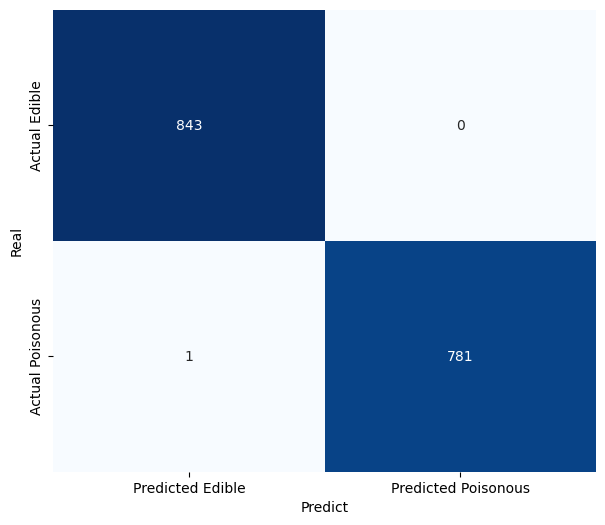

In [63]:
tree_y_pred = best_tree_model.predict(X_test)
tree_y_prob = best_tree_model.predict_proba(X_test)[:, 1]

tree_confusion_matrix = metrics.confusion_matrix(y_test, tree_y_pred)

pd.DataFrame(
    tree_confusion_matrix,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)

print_confusion_matrix(tree_confusion_matrix)

In [64]:
get_eval_metrics(tree_confusion_matrix)

All of the metrics:

True Positive (TP): 781
True Negative (TN): 843
False Positive (FP): 0
False Negative (FN): 1

Accuracy: 0.999
Recall (Sensitivity): 0.999
Precision: 1.000
Specificity: 1.000

TPR: 0.999
FPR: 0.0


In [65]:
tree_roc_auc = roc_auc_score(y_test, tree_y_prob)
print(f"ROC AUC: {tree_roc_auc:.4f}")

tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, tree_y_prob, drop_intermediate=False)

ROC AUC: 1.0000


In [66]:
tree_feature_importance = (
    pd.Series(best_tree_model.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
)

tree_feature_importance.head(15).to_frame("importance")

,importance
odor_n,0.630941
bruises_t,0.168303
odor_p,0.095015
odor_f,0.062882
cap-color_y,0.011387
gill-color_r,0.010941
gill-spacing_w,0.006448
cap-color_n,0.003484
cap-surface_g,0.001838
gill-color_g,0.001758


In [67]:
plot_roc_curve(tree_fpr,tree_tpr,tree_roc_auc)

In [68]:
plot_roc_curve_styled(tree_fpr, tree_tpr, tree_roc_auc)

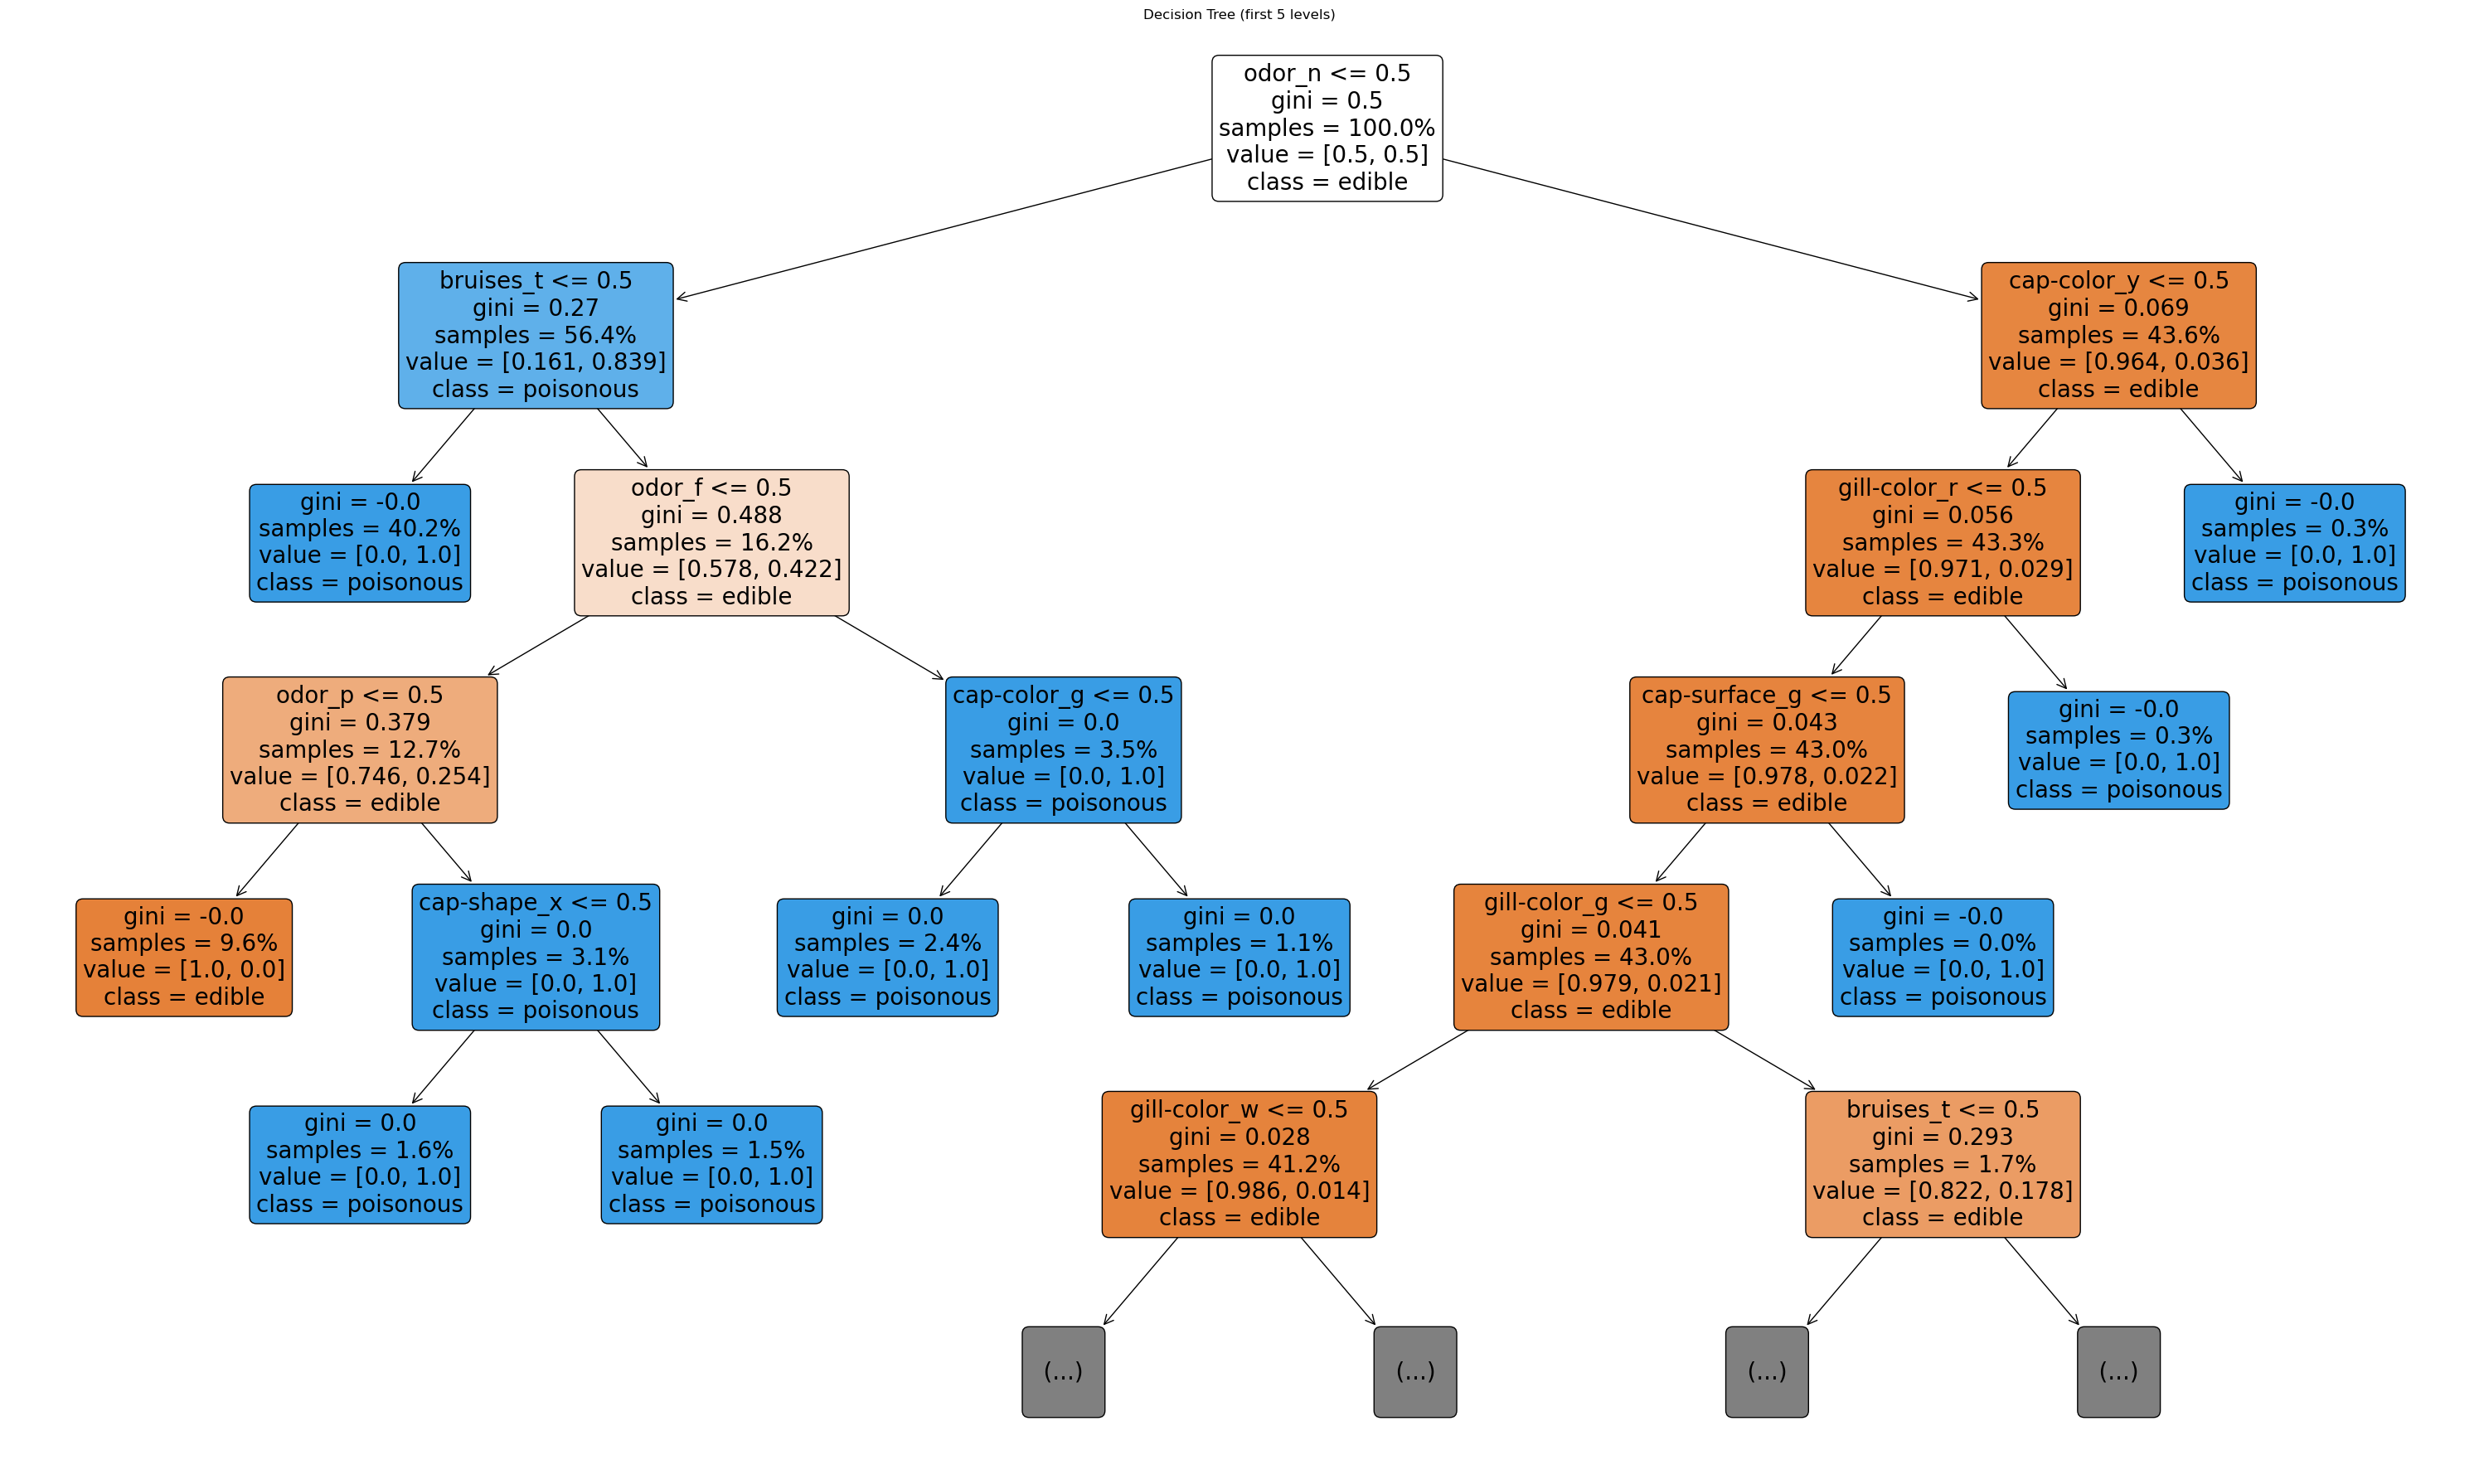

In [69]:
plt.figure(figsize=(30, 18))
plot_tree(
    best_tree_model,
    feature_names=X.columns,
    class_names=['edible', 'poisonous'],
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=5
)
plt.title('Decision Tree (first 5 levels)')
plt.tight_layout()


## Support Vector Machine

In [70]:
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, class_weight="balanced", random_state=42))
])

svm_param_grid = [
    {
        "svm__kernel": ["linear"],
        "svm__C": np.logspace(-2, 3, 6)
    },
    {
        "svm__kernel": ["rbf", "sigmoid"],
        "svm__C": np.logspace(-2, 3, 6),
        "svm__gamma": ["scale", "auto"]
    },
    {
        "svm__kernel": ["poly"],
        "svm__C": np.logspace(-2, 3, 6),
        "svm__gamma": ["scale", "auto"],
        "svm__degree": [2, 3]
    }
]

svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring={
        "accuracy": "accuracy",
        "f1": "f1",
        "roc_auc": "roc_auc",
        "recall": "recall"
    },
    refit="recall",
    cv=5,
    n_jobs=-1,
    verbose=0
)

svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid=[{'svm__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'svm__kernel': ['linear']},
                         {'svm__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'svm__gamma': ['scale', 'auto'],
                          'svm__kernel': ['rbf', 'sigmoid']},
                         {'svm__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'svm__degree': [2, 3],
                          'svm__gamma': ['scale', 'auto'],
                          'svm__kernel': ['poly']}],
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [71]:
print(f"Best CV Recall: {svm_grid_search.best_score_:.4f}")
print("Best Params:", svm_grid_search.best_params_)

Best CV Recall: 0.9974
Best Params: {'svm__C': 100.0, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}


In [72]:
svm_cv_results = (
    pd.DataFrame(svm_grid_search.cv_results_)
    .sort_values("rank_test_accuracy")
    [
        [
            "param_svm__kernel",
            "param_svm__C",
            "param_svm__gamma",
            "param_svm__degree",
            "mean_test_accuracy",
            "mean_test_f1",
            "mean_test_roc_auc"
        ]
    ]
)

svm_cv_results.head(10)


,param_svm__kernel,param_svm__C,param_svm__gamma,param_svm__degree,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
44,poly,10.0,scale,3,0.998461,0.998402,0.999636
45,poly,10.0,auto,3,0.998461,0.998402,0.999636
20,rbf,10.0,auto,NaN,0.998307,0.998243,0.999711
18,rbf,10.0,scale,NaN,0.998307,0.998243,0.999711
43,poly,10.0,auto,2,0.998153,0.998083,0.999785
42,poly,10.0,scale,2,0.998153,0.998083,0.999785
47,poly,100.0,auto,2,0.998153,0.998085,0.999751
46,poly,100.0,scale,2,0.998153,0.998085,0.999751
50,poly,1000.0,scale,2,0.998153,0.998085,0.999605
51,poly,1000.0,auto,2,0.998153,0.998085,0.999605


In [73]:
best_svm_model = svm_grid_search.best_estimator_

svm_cv_recall = cross_val_score(best_svm_model, X, y, cv=10, scoring="recall")
svm_cv_accuracy = cross_val_score(best_svm_model, X, y, cv=10, scoring="accuracy")
svm_cv_f1 = cross_val_score(best_svm_model, X, y, cv=10, scoring="f1")
svm_cv_auc = cross_val_score(best_svm_model, X, y, cv=10, scoring="roc_auc")

svm_eval = pd.DataFrame({
    "metric": [
        "Train Accuracy",
        "Test Accuracy",
        "CV Accuracy (mean)",
        "CV Accuracy (std)",
        "CV Recall (mean)",
        "CV F1 (mean)",
        "CV ROC-AUC (mean)"
    ],
    "score": [
        best_svm_model.score(X_train, y_train),
        best_svm_model.score(X_test, y_test),
        svm_cv_accuracy.mean(),
        svm_cv_accuracy.std(),
        svm_cv_recall.mean(),
        svm_cv_f1.mean(),
        svm_cv_auc.mean()
    ]
})

svm_eval


,metric,score
0,Train Accuracy,0.998923
1,Test Accuracy,0.999385
2,CV Accuracy (mean),0.959763
3,CV Accuracy (std),0.084608
4,CV Recall (mean),0.939541
5,CV F1 (mean),0.947960
6,CV ROC-AUC (mean),0.966522


In [74]:
print('All of the scores:', svm_cv_recall,'\n')
print('Mean of the scores:', round(svm_cv_recall.mean(),4))

All of the scores: [0.42857143 1.         1.         0.99744898 0.98469388 0.98469388
 1.         1.         1.         1.        ] 

Mean of the scores: 0.9395


Here is the correlation matrix:


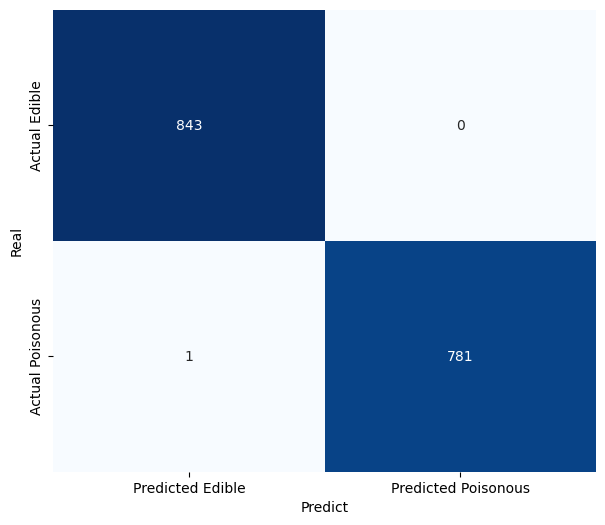

In [75]:
svm_y_pred = best_svm_model.predict(X_test)
svm_y_prob = best_svm_model.predict_proba(X_test)[:, 1]

svm_confusion_matrix = metrics.confusion_matrix(y_test, svm_y_pred)

pd.DataFrame(
    svm_confusion_matrix,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)
print_confusion_matrix(svm_confusion_matrix)
#print(metrics.classification_report(y_test, svm_y_pred, target_names=["edible", "poisonous"]))


In [76]:
get_eval_metrics(svm_confusion_matrix)

All of the metrics:

True Positive (TP): 781
True Negative (TN): 843
False Positive (FP): 0
False Negative (FN): 1

Accuracy: 0.999
Recall (Sensitivity): 0.999
Precision: 1.000
Specificity: 1.000

TPR: 0.999
FPR: 0.0


In [77]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(
    y_test,
    svm_y_prob,
    drop_intermediate=False
)
svm_roc_auc = auc(svm_fpr, svm_tpr)
print(f"ROC AUC: {svm_roc_auc:.5f}")

ROC AUC: 0.99983


In [78]:
svm_model = best_svm_model.named_steps["svm"]

svm_support_summary = pd.DataFrame({
    "class": ["edible", "poisonous"],
    "n_support_vectors": svm_model.n_support_,
    "support_fraction": svm_model.n_support_ / svm_model.n_support_.sum()
})
svm_support_summary


,class,n_support_vectors,support_fraction
0,edible,131,0.595455
1,poisonous,89,0.404545


In [79]:
plot_roc_curve(svm_fpr, svm_tpr, svm_roc_auc)

In [80]:
plot_roc_curve_styled(svm_fpr, svm_tpr, svm_roc_auc)

## Random Forest Classifier

In [81]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

rf_model = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring={
        "accuracy": "accuracy",
        "f1": "f1",
        "roc_auc": "roc_auc",
        "recall": "recall"
    },
    refit="recall",
    cv=5,
    n_jobs=-1,
    verbose=0
)

rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [82]:
print(f"Best CV Recall: {rf_grid_search.best_score_:.4f}")
print("Best Params:", rf_grid_search.best_params_)

Best CV Recall: 0.9974
Best Params: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [83]:
rf_cv_results = (
    pd.DataFrame(rf_grid_search.cv_results_)
    .sort_values("rank_test_accuracy")
    [
        [
            "param_n_estimators",
            "param_max_depth",
            "param_min_samples_split",
            "param_min_samples_leaf",
            "param_max_features",
            "param_bootstrap",
            "mean_test_accuracy",
            "mean_test_f1",
            "mean_test_roc_auc"
        ]
    ]
)

rf_cv_results.head(10)

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_bootstrap,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
50,200,20,5,1,sqrt,False,0.998769,0.998722,0.999948
48,200,20,2,1,sqrt,False,0.998769,0.998722,0.999980
49,400,20,2,1,sqrt,False,0.998615,0.998562,0.999979
19,400,20,5,1,sqrt,True,0.998615,0.998562,0.999958
18,200,20,5,1,sqrt,True,0.998615,0.998562,0.999963
56,200,20,2,1,log2,False,0.998615,0.998562,0.999980
57,400,20,2,1,log2,False,0.998615,0.998562,0.999979
51,400,20,5,1,sqrt,False,0.998615,0.998562,0.999950
2,200,None,5,1,sqrt,True,0.998615,0.998562,0.999958
44,200,None,2,2,log2,False,0.998461,0.998402,0.999940


In [84]:
best_rf_model = rf_grid_search.best_estimator_

rf_cv_recall = cross_val_score(best_rf_model, X, y, cv=10, scoring="recall")
rf_cv_accuracy = cross_val_score(best_rf_model, X, y, cv=10, scoring="accuracy")
rf_cv_f1 = cross_val_score(best_rf_model, X, y, cv=10, scoring="f1")
rf_cv_auc = cross_val_score(best_rf_model, X, y, cv=10, scoring="roc_auc")

rf_eval = pd.DataFrame({
    "metric": [
        "Train Accuracy",
        "Test Accuracy",
        "CV Accuracy (mean)",
        "CV Accuracy (std)",
        "CV Recall (mean)",
        "CV F1 (mean)",
        "CV ROC-AUC (mean)"
    ],
    "score": [
        best_rf_model.score(X_train, y_train),
        best_rf_model.score(X_test, y_test),
        rf_cv_accuracy.mean(),
        rf_cv_accuracy.std(),
        rf_cv_recall.mean(),
        rf_cv_f1.mean(),
        rf_cv_auc.mean()
    ]
})

rf_eval


,metric,score
0,Train Accuracy,0.998923
1,Test Accuracy,0.999385
2,CV Accuracy (mean),0.953734
3,CV Accuracy (std),0.098395
4,CV Recall (mean),0.932653
5,CV F1 (mean),0.937962
6,CV ROC-AUC (mean),0.998713


In [85]:
print('All of the scores:', rf_cv_recall,'\n')
print('Mean of the scores:', round(rf_cv_recall.mean(),4))

All of the scores: [0.34693878 1.         1.         0.99744898 0.9872449  0.99489796
 1.         1.         1.         1.        ] 

Mean of the scores: 0.9327


Here is the correlation matrix:


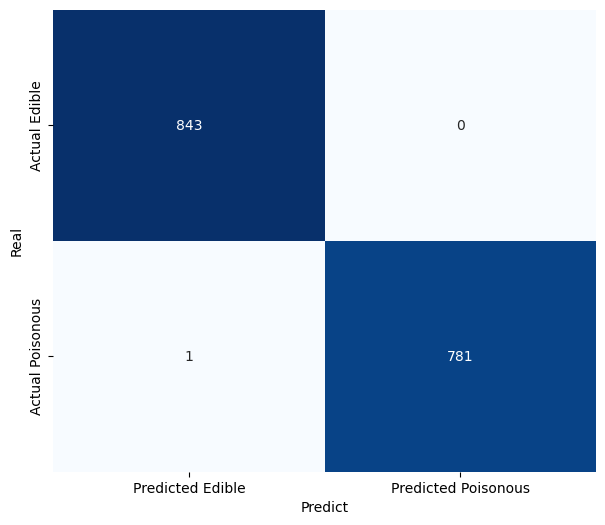

In [86]:
rf_y_pred = best_rf_model.predict(X_test)
rf_y_prob = best_rf_model.predict_proba(X_test)[:, 1]

rf_confusion_matrix = metrics.confusion_matrix(y_test, rf_y_pred)

pd.DataFrame(
    rf_confusion_matrix,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)

print_confusion_matrix(rf_confusion_matrix)
#print(metrics.classification_report(y_test, rf_y_pred, target_names=["edible", "poisonous"]))


In [87]:
get_eval_metrics(rf_confusion_matrix)

All of the metrics:

True Positive (TP): 781
True Negative (TN): 843
False Positive (FP): 0
False Negative (FN): 1

Accuracy: 0.999
Recall (Sensitivity): 0.999
Precision: 1.000
Specificity: 1.000

TPR: 0.999
FPR: 0.0


In [88]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(
    y_test,
    rf_y_prob,
    drop_intermediate=False
)
rf_roc_auc = auc(rf_fpr, rf_tpr)
print(f"ROC AUC: {rf_roc_auc:.5f}")

ROC AUC: 1.00000


In [89]:
rf_feature_importance = (
    pd.Series(best_rf_model.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
)

rf_feature_importance.head(15).to_frame("importance")


,importance
odor_n,0.264149
odor_f,0.189278
gill-size_n,0.128485
bruises_t,0.103430
gill-spacing_w,0.049169
odor_p,0.026925
odor_l,0.021433
cap-color_y,0.020068
odor_s,0.020040
odor_y,0.019523


In [90]:
plot_roc_curve(rf_fpr, rf_tpr, rf_roc_auc)

In [91]:
plot_roc_curve_styled(rf_fpr, rf_tpr, rf_roc_auc)

In [92]:
end_time = time.time()  
time_passed = end_time - start_time
print(f"Time passed: {time_passed:.2f} seconds")    

Time passed: 349.10 seconds


In [93]:
rf_grid_search

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [94]:
import joblib
joblib.dump(best_rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']